# COMP4318/5318 Assignment 2: Image Classification

### Group number: 77, SID1: 540969766, SID2: 540798188, SID3:  , SID4: 

This template notebook includes code to load the  dataset and a skeleton for the main sections that should be included in the notebook. Please stick to this struture for your submitted notebook.

Please focus on making your code clear, with appropriate variable names and whitespace. Include comments and markdown text to aid the readability of your code where relevant. See the specification and marking criteria in the associated specification to guide you when completing your implementation.

## Setup and dependencies
Please use this section to list and set up all your required libraries/dependencies and your plotting environment. 

In [60]:
# Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


# Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    BaggingClassifier
)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# FCNN and CNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from kerastuner import HyperParameters, RandomSearch
from tensorflow import keras
from tensorflow.keras import layers

import itertools
import warnings
from sklearn.exceptions import ConvergenceWarning


warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="The max_iter was reached which means the coef_ did not converge")


## 1. Data loading, exploration, and preprocessing


Code to load the dataset is provided in the following cell. Please proceed with your data exploration and preprocessing in the remainder of this section.

### Data loading

In [61]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

### Data exploration

In [62]:
# Check the shape of the dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000,) (10000, 32, 32, 3) (10000,)


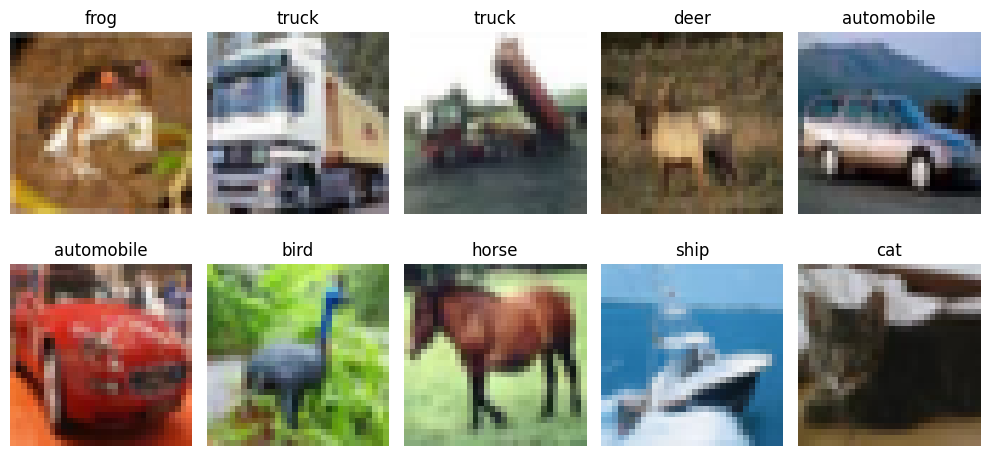

In [63]:
# Plot some examples of the dataset with labels
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[i])
    # Handle both (50000, 1) and (50000,) cases
    label_index = y_train[i] if np.ndim(y_train) == 1 else y_train[i][0]
    plt.title(class_names[label_index])
    plt.axis('off')
plt.tight_layout()
plt.show()

### Preprocessing

In [64]:
# Check the model's performance with subset of the whole dataset

# Flatten the labels for classical models
y_train = y_train.flatten()
y_test = y_test.flatten()

label_counts = pd.Series(y_train).value_counts().sort_index()
print(f"Label counts: {label_counts}\n\n")

# Normalize pixel values for all models 
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# One-hot encode labels for Neural Networks 
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Flatten images for classical models
X_train_flat = X_train_norm.reshape((X_train.shape[0], -1))
X_test_flat = X_test_norm.reshape((X_test.shape[0], -1))

# Subsample for classical models to prevent overload
X_small, _, y_small, _ = train_test_split(
    X_train_flat, y_train, train_size=2000, stratify=y_train, random_state=42
)
X_test_small, _, y_test_small, _ = train_test_split(
    X_test_flat, y_test, train_size=400, stratify=y_test, random_state=42
)
# Normalize images for neural networks
X_small_norm = X_small.astype("float32") / 255.0
X_test_small_norm = X_test_small.astype("float32") / 255.0

X_small_norm = X_train_norm[:2000]
y_small_cat = y_train_cat[:2000]
X_test_small_norm = X_test_norm[:400]
y_test_small_cat = y_test_cat[:400]

print("Reduced classical training shape:", X_small.shape)
print("Reduced classical test shape:", X_test_small.shape)

Label counts: 0    5000
1    5000
2    5000
3    5000
4    5000
5    5000
6    5000
7    5000
8    5000
9    5000
Name: count, dtype: int64


Reduced classical training shape: (2000, 3072)
Reduced classical test shape: (400, 3072)


In [65]:
y_train[1:10]

array([9, 9, 4, 1, 1, 2, 7, 8, 3])

In [66]:
X_small_norm.shape

(2000, 32, 32, 3)

In [67]:
# Data Augmentation to introduce more variation in the training data
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train)

### Examples of preprocessed data
Please print/display some examples of your preprocessed data here.

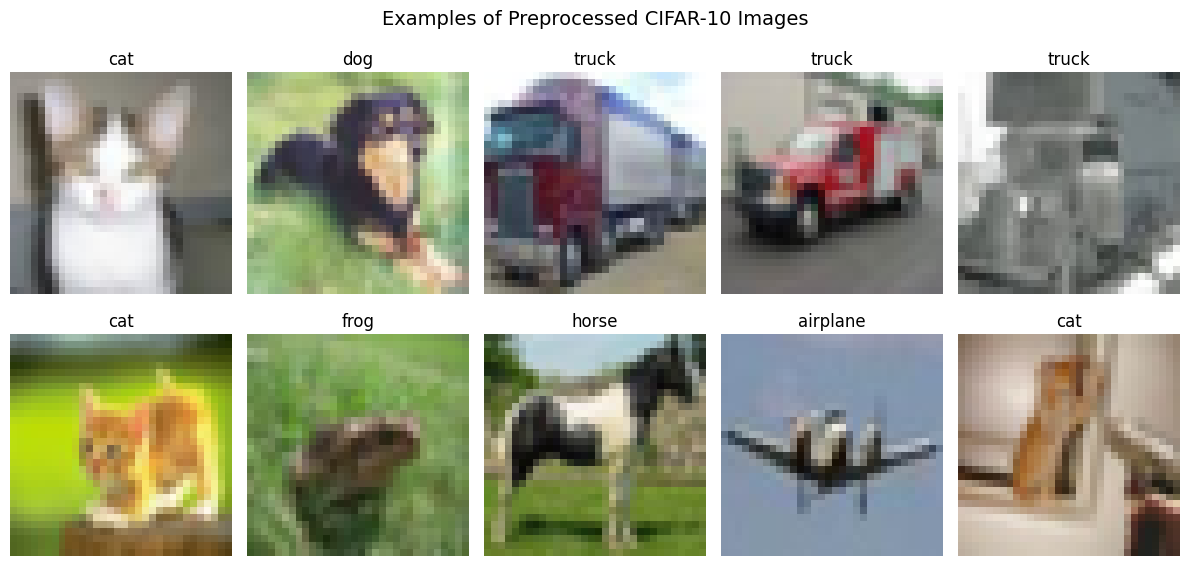

In [68]:
# Based on https://www.cs.toronto.edu/~kriz/cifar.html
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Randomly choose 10 samples
indices = np.random.choice(len(X_train), 10, replace=False)

plt.figure(figsize=(12, 6))
for i, idx in enumerate(indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train[idx])
    plt.title(class_names[y_train[idx]])
    plt.axis('off')
plt.suptitle("Examples of Preprocessed CIFAR-10 Images", fontsize=14)
plt.tight_layout()
plt.show()

## 2. Algorithm design and setup

### Algorithm of choice from first six weeks of course

In [69]:
class ClassificationModel:

    def logistic_regression(self):
        log_reg = LogisticRegression(random_state=42) 
        hyperparameter = {"model__C": [0.1, 1.0], "model__max_iter": [500, 1000]}
        return log_reg, hyperparameter

    def svm(self):
        svm = SVC(random_state=42)
        hyperparameter = {"model__C": [0.1, 1, 10], "model__kernel": ["linear", "rbf"]}
        return svm, hyperparameter

    def decision_tree(self):
        dt = DecisionTreeClassifier(random_state=42)
        hyperparameter = {"model__max_depth": [5, 10, 20, None], "model__min_samples_split": [2, 5, 10]}
        return dt, hyperparameter
    
    def random_forest(self, n_estimators = None, max_depth = None, min_samples_leaf = None, bootstrap = True):
        rf = RandomForestClassifier(random_state=42)
        hyperparameter = {"model__n_estimators":[50, 100, 200] if n_estimators == None else n_estimators,
                           "model__max_depth": [5, 10, 20, 30] if max_depth == None else max_depth,
                           "model__min_samples_leaf": [2, 5, 10] if min_samples_leaf == None else min_samples_leaf}
        return rf, hyperparameter
    
    def ada_boost(self):
        adb = AdaBoostClassifier(random_state=42)
        hyperparameter = {"model__n_estimators": [50, 100], "model__learning_rate": [0.01, 0.1]}
        return adb, hyperparameter
    
    def gradient_boost(self):
        gb = GradientBoostingClassifier(random_state=42)
        hyperparameter = {
            "model__n_estimators": [50, 100],
            "model__learning_rate": [0.01, 0.1],
            "model__max_depth": [1, 3]
        }
        return gb, hyperparameter
    
    def bagging(self):
        bag = BaggingClassifier()
        hyperparameter = {"model__n_estimators": [50, 100]}
        return bag, hyperparameter
    
    def naivebayes(self):
        nb = GaussianNB()
        hyperparameter = {}
        return nb, hyperparameter
    
    def cnn(self, filters1=32, filters2=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001, **kwargs):
        model = Sequential([
            Input(shape=(32, 32, 3)),
            Conv2D(filters1, (kernel_size, kernel_size), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2)),

            Conv2D(filters2, (kernel_size, kernel_size), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2,2)),

            Flatten(),
            Dense(128, activation='relu'),
            Dropout(dropout_rate),
            Dense(10, activation='softmax')
        ])

        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    def mlp(self, hidden_units=256, dropout_rate=0.3, learning_rate=0.001):
        model = Sequential([
            Input(shape=(32, 32, 3)),
            Flatten(),
            Dense(hidden_units, activation='relu'),
            Dropout(dropout_rate),
            Dense(hidden_units // 2, activation='relu'),
            Dropout(dropout_rate / 2),
            Dense(10, activation='softmax')
        ])
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model
    
    def tuning_mlp(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(32, 32, 3)))  # flattened CIFAR-10 images
        model.add(keras.layers.Flatten())
        # Tune number of hidden layers
        for i in range(hp.Int('num_layers', 1, 5)):
            model.add(layers.Dense(
                units=hp.Choice(f'units_{i}', [128, 256, 512]),
                activation='relu'
            ))
            model.add(layers.Dropout(
                hp.Float(f'dropout_{i}', 0.1, 0.1)
            ))

        # Output layer
        model.add(layers.Dense(10, activation='softmax'))

        # Compile with sparse loss so you can feed integer labels
        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')
            ),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        return model
    
    def tuning_cnn(self, hp):
        model = Sequential()
    
        # First conv block
        model.add(Conv2D(
            filters=hp.Choice('filters1', [32, 64]),
            kernel_size=(3,3),
            activation='relu',
            padding='same',
            input_shape=(32,32,3)
        ))
        model.add(BatchNormalization())
        model.add(Conv2D(
            filters=hp.Choice('filters1_2', [32, 64]),
            kernel_size=(3,3),
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(hp.Float('dropout1', 0.2, 0.5, step=0.05)))
        
        # Second conv block
        model.add(Conv2D(
            filters=hp.Choice('filters2', [64, 128]),
            kernel_size=(3,3),
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(Conv2D(
            filters=hp.Choice('filters2_2', [64, 128]),
            kernel_size=(3,3),
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(hp.Float('dropout2', 0.2, 0.5, step=0.05)))
        
        # Third conv block
        model.add(Conv2D(
            filters=hp.Choice('filters3', [128, 256]),
            kernel_size=(3,3),
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(Conv2D(
            filters=hp.Choice('filters3_2', [128, 256]),
            kernel_size=(3,3),
            activation='relu',
            padding='same'
        ))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(hp.Float('dropout3', 0.2, 0.5, step=0.05)))
        
        # Dense layers
        model.add(Flatten())
        model.add(Dense(hp.Choice('dense_units', [128, 256]), activation='relu'))
        model.add(Dropout(hp.Float('dense_dropout', 0.2, 0.5, step=0.05)))
        
        # Output layer
        model.add(Dense(10, activation='softmax'))
        
        # Compile
        lr = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
        model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        )
    
        return model
        
    def run_model(self, model,
               X_train, y_train,
               X_test, y_test,
               use_pca=False, n_components=0.95,
               verbose=1):
        """
        Train and evaluate a single model (optionally with PCA), without hyperparameter tuning.

        Args:
            model: sklearn estimator
            X_train, y_train: training data
            X_test, y_test: testing data
            use_pca (bool): whether to apply PCA
            n_components (float or int): PCA components (variance or count)
            verbose (int): verbosity level

        Returns:
            best_model: trained pipeline
            test_acc: test accuracy
        """

        # --- Ensure labels are integers ---
        y_train_int = y_train.argmax(axis=1) if y_train.ndim > 1 and y_train.shape[1] > 1 else y_train
        y_test_int  = y_test.argmax(axis=1)  if y_test.ndim > 1 and y_test.shape[1] > 1 else y_test

        # --- Build pipeline ---
        steps = []
        if use_pca:
            steps.append(("reduce", PCA(n_components=n_components)))
        steps.append(("model", model))
        pipe = Pipeline(steps)

        # --- Train ---
        pipe.fit(X_train, y_train_int)

        # --- Predict ---
        y_pred_labels = pipe.predict(X_test)

        # --- Metrics ---
        accuracy_val = accuracy_score(y_test_int, y_pred_labels)
        f1_val       = f1_score(y_test_int, y_pred_labels, average='macro')

        if verbose:
            print(f"Model trained. Accuracy = {accuracy_val:.4f}, F1-score = {f1_val:.4f}")

        return pipe, accuracy_val, f1_val
    
    def tune_model(self, model, param_grid,
               X_train, y_train,
               X_test, y_test,
               use_pca=False, n_components=0.95,
               cv_folds=10, verbose=1):
        """
        Train/tune a single model (optionally with PCA) using GridSearchCV.

        Args:
            model: sklearn estimator
            param_grid (dict): grid for GridSearchCV (can be empty for no tuning)
            X_train, y_train: training data
            X_test, y_test: testing data
            use_pca (bool): whether to apply PCA
            n_components (float or int): PCA components (variance or count)
            cv_folds (int): number of CV folds
            verbose (int): verbosity level

        Returns:
            best_model: trained pipeline (best estimator)
            test_acc: test accuracy
        """

        # Build pipeline
        steps = []
        if use_pca:
            steps.append(("reduce", PCA(n_components=n_components)))
        steps.append(("model", model))
        pipe = Pipeline(steps)

        # Check if tuning is needed
        if not param_grid:
            pipe.fit(X_train, y_train)
            acc = accuracy_score(y_test, pipe.predict(X_test))
            print(f"Model trained without tuning. Test Accuracy = {acc:.4f}")
            return pipe, acc

        # GridSearchCV for testing the hyperparameters
        search = GridSearchCV(
            estimator=pipe,
            param_grid=param_grid,
            cv=cv_folds,
            n_jobs=-1,
            scoring="accuracy",
            verbose=verbose
        )

        search.fit(X_train, y_train)
        best_model = search.best_estimator_

        # Evaluate model's performance based on the best hyperparameters
        test_acc = accuracy_score(y_test, best_model.predict(X_test))
        print(f"Best Params = {search.best_params_}, Test Accuracy = {test_acc:.4f}")

        return best_model, test_acc

        
classification_model = ClassificationModel()



In [70]:
# Define base models
models = {
    "Logistic Regression": classification_model.logistic_regression()[0],
    "SVM": classification_model.svm()[0],
    "Decision Tree": classification_model.decision_tree()[0],
    "Random Forest": classification_model.random_forest()[0],
    "AdaBoost": classification_model.ada_boost()[0],
    "Gradient Boosting": classification_model.gradient_boost()[0],
    "Bagging": classification_model.bagging()[0],
    "Naive Bayes": classification_model.naivebayes()[0]
}

use_pca_flags = {
    "Logistic Regression": False,
    "SVM": False,
    "Decision Tree": False,
    "Random Forest": False,
    "AdaBoost": False,
    "Gradient Boosting": True,
    "Bagging": False,
    "Naive Bayes": False
}

tuned_results = {}
best_models = {}

# Training the models without any hyperparameter tuning
for name, model in models.items():
    print(f"\n Training {name}...")
    use_pca = use_pca_flags.get(name, False)
    
    pipe, test_acc, test_f1 = classification_model.run_model(
        model=model,
        X_train=X_small,
        y_train=y_small,
        X_test=X_test_small,
        y_test=y_test_small,
        use_pca=use_pca,
        n_components=0.95
    )

    tuned_results[name] = {"accuracy": test_acc, "f1_score": test_f1}

    
# Overall performance of the models
print(f"\nOverall performance of the models: {tuned_results}")


 Training Logistic Regression...
Model trained. Accuracy = 0.2825, F1-score = 0.2837

 Training SVM...
Model trained. Accuracy = 0.4175, F1-score = 0.4104

 Training Decision Tree...
Model trained. Accuracy = 0.2300, F1-score = 0.2280

 Training Random Forest...
Model trained. Accuracy = 0.4075, F1-score = 0.3990

 Training AdaBoost...
Model trained. Accuracy = 0.2225, F1-score = 0.2164

 Training Gradient Boosting...
Model trained. Accuracy = 0.3850, F1-score = 0.3830

 Training Bagging...
Model trained. Accuracy = 0.3175, F1-score = 0.3199

 Training Naive Bayes...
Model trained. Accuracy = 0.3150, F1-score = 0.2812

Overall performance of the models: {'Logistic Regression': {'accuracy': 0.2825, 'f1_score': 0.2837371650056725}, 'SVM': {'accuracy': 0.4175, 'f1_score': 0.41042169654066124}, 'Decision Tree': {'accuracy': 0.23, 'f1_score': 0.22797452168611473}, 'Random Forest': {'accuracy': 0.4075, 'f1_score': 0.39898999471076185}, 'AdaBoost': {'accuracy': 0.2225, 'f1_score': 0.21641246

### Fully connected neural network

In [71]:

mlp_base = KerasClassifier(
    model=classification_model.mlp(),
    epochs=50,
    batch_size=64,
    verbose=1
)

# Training with small normalized dataset)
mlp_base.fit(X_small_norm, y_small_cat, validation_data=(X_test_small_norm, y_test_small_cat))

# Predict on test set (small version as well)
y_pred_mlp_base = mlp_base.predict(X_test_small_norm)

# Convert one-hot encoded labels to integer
y_true_mlp_base = y_test_small_cat.argmax(axis=1)

# If predictions are probabilities, convert to class index
if y_pred_mlp_base.ndim > 1:
    y_pred_mlp_base = y_pred_mlp_base.argmax(axis=1)

# Compute metrics
mlp_base_acc = accuracy_score(y_true_mlp_base, y_pred_mlp_base)
mlp_base_f1 = f1_score(y_true_mlp_base, y_pred_mlp_base, average='macro')  # use y_true, not y_test
print(f"MLP Base Test Accuracy: {mlp_base_acc:.4f}, F1-score: {mlp_base_f1:.4f}")


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1101 - loss: 2.4939 - val_accuracy: 0.1775 - val_loss: 2.1623
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1836 - loss: 2.1727 - val_accuracy: 0.2575 - val_loss: 2.1231
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2123 - loss: 2.0964 - val_accuracy: 0.1925 - val_loss: 2.0505
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2644 - loss: 2.0347 - val_accuracy: 0.2700 - val_loss: 2.0033
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2352 - loss: 2.0442 - val_accuracy: 0.2250 - val_loss: 1.9981
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2917 - loss: 1.9736 - val_accuracy: 0.2500 - val_loss: 1.9755
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2731 - loss: 1.9618 - val_accuracy: 0.2650 - val_loss: 2.0217
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2896 - loss: 1.9255 - val_accuracy: 0.3050 - val_loss:

### Convolutional neural network

In [72]:
cnn = classification_model.cnn()

# Define the CNN model
cnn_base = KerasClassifier(
    model=cnn,
    epochs=50,
    batch_size=64,
    verbose=1
)

# Compile CNN
cnn.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

cnn.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 545,482 (2.08 MB)

 Trainable params: 545,290 (2.08 MB)

 Non-trainable params: 192 (768.00 B)

In [73]:
# Training the CNN model
cnn_base.fit(
    X_small_norm, y_small_cat,
    validation_data=(X_test_small_norm, y_test_small_cat)
)

# Predict on small test set
y_pred_cnn_base = cnn_base.predict(X_test_small_norm)

# Convert one-hot encoded labels to integer
y_true_cnn_base = y_test_small_cat.argmax(axis=1)

# If predictions are probabilities, convert to class index
if y_pred_cnn_base.ndim > 1:
    y_pred_cnn_base = y_pred_cnn_base.argmax(axis=1)

# Compute metrics
cnn_base_acc = accuracy_score(y_true_cnn_base, y_pred_cnn_base)
cnn_base_f1 = f1_score(y_true_cnn_base, y_pred_cnn_base, average='macro')  # use y_true, not y_test -> integer metri
print(f"CNN Base Test Accuracy: {cnn_base_acc:.4f}, F1-score: {cnn_base_f1:.4f}")

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.1975 - loss: 2.7471 - precision: 0.2537 - recall: 0.0774 - val_accuracy: 0.1675 - val_loss: 2.2495 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3749 - loss: 1.7317 - precision: 0.5832 - recall: 0.1315 - val_accuracy: 0.1425 - val_loss: 2.3861 - val_precision: 1.0000 - val_recall: 0.0025
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4573 - loss: 1.5061 - precision: 0.6221 - recall: 0.2416 - val_accuracy: 0.1150 - val_loss: 2.8747 - val_precision: 0.1577 - val_recall: 0.0950
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5061 - loss: 1.3546 - precision: 0.6597 - recall: 0.3378 - val_accuracy: 0.1225 - val_loss: 3.1533 - val_precision: 0.1434 - val_recall: 0.1000
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.5887 - loss: 1.1582 - precision: 0.7542 - recall: 0.4348 - val_accuracy: 0.1400 - val_loss:

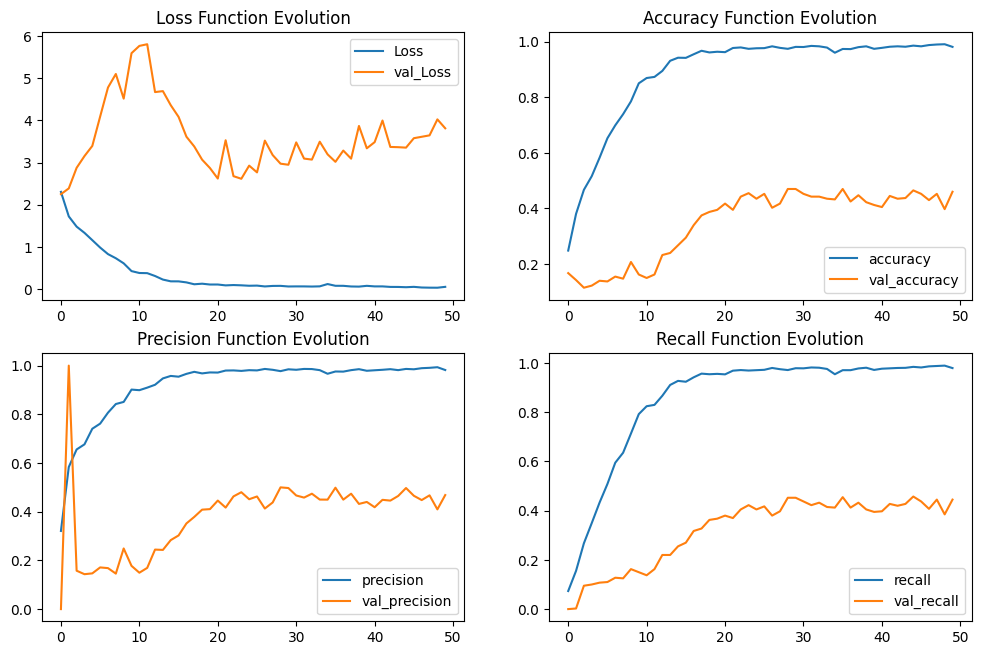

In [74]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(cnn_base.history_['loss'], label='Loss')
plt.plot(cnn_base.history_['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(cnn_base.history_['accuracy'], label='accuracy')
plt.plot(cnn_base.history_['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(cnn_base.history_['precision'], label='precision')
plt.plot(cnn_base.history_['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(cnn_base.history_['recall'], label='recall')
plt.plot(cnn_base.history_['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


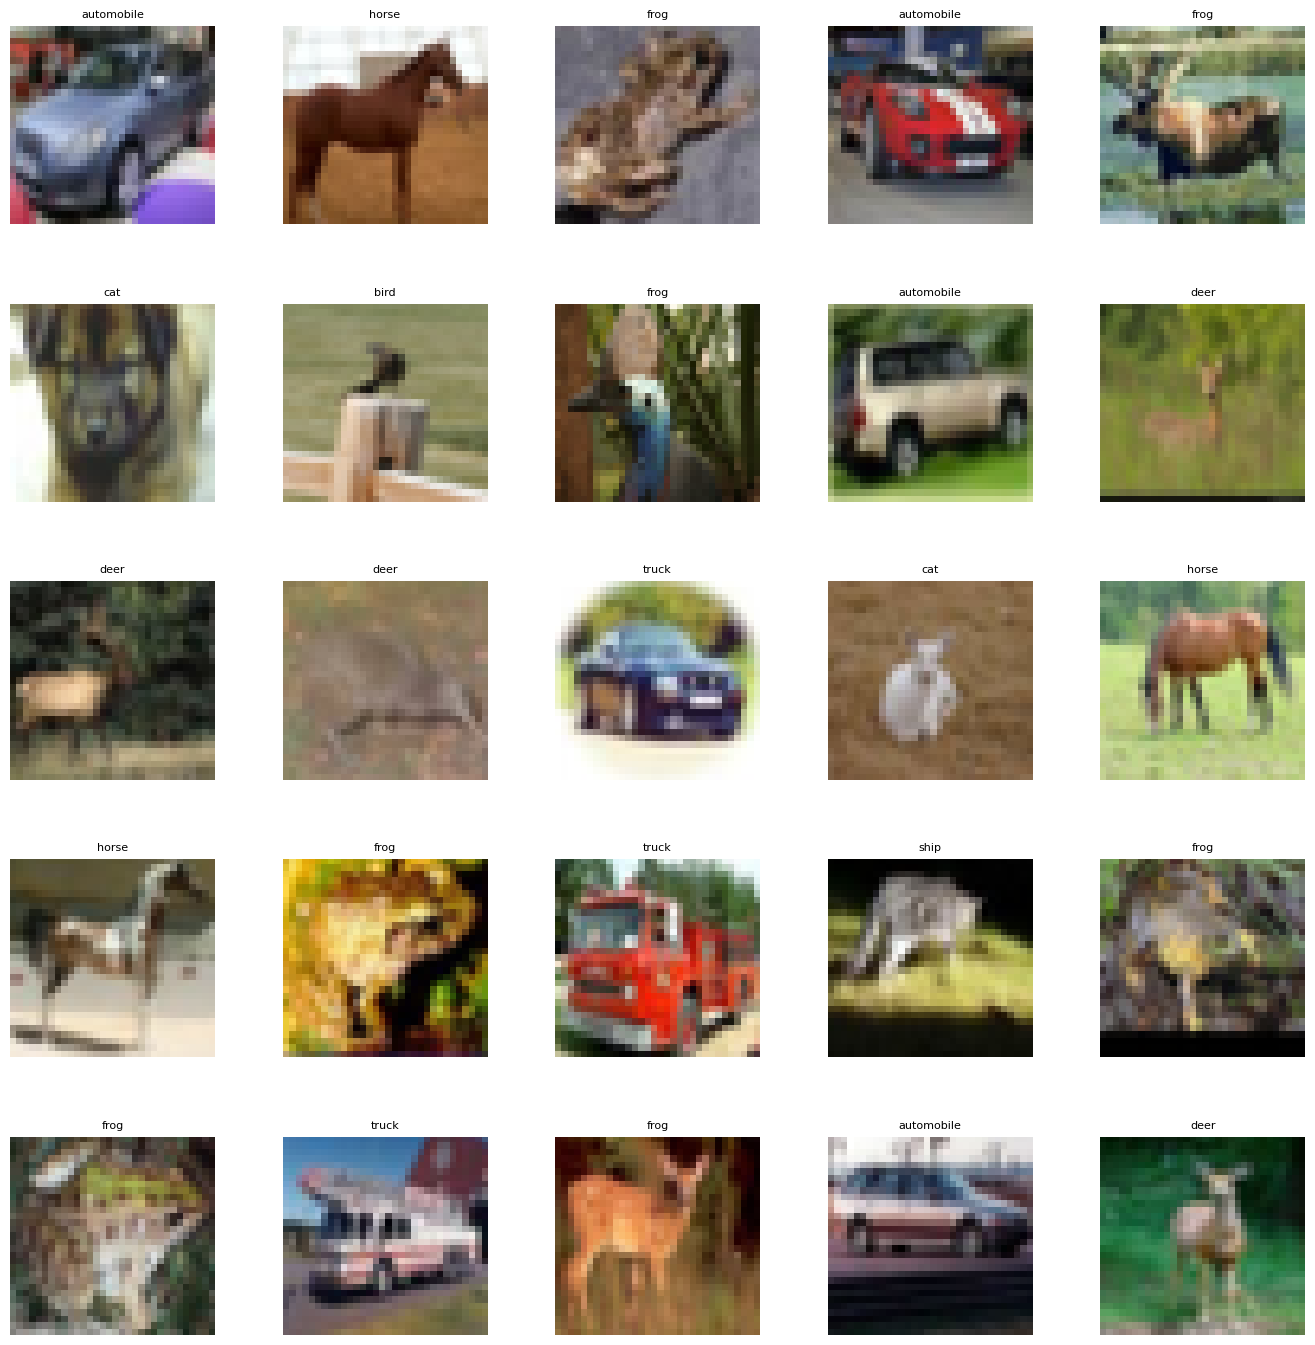

In [75]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
y_pred = cnn.predict(X_test_norm)
y_pred = np.argmax(y_pred, axis=1)

# Define the dimensions of the plot grid 
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # Read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [76]:
tuned_results['CNN'] = {"accuracy": cnn_base_acc, "f1_score": cnn_base_f1}
tuned_results['MLP'] = {"accuracy": mlp_base_acc, "f1_score": mlp_base_f1}
# Convert dictionary to DataFrame
results_df = pd.DataFrame.from_dict(tuned_results, orient='index')  
results_df.index.name = 'Model'
results_df.reset_index(inplace=True)

print("\nModel Performance Summary:")
print(results_df)


Model Performance Summary:
                 Model  accuracy  f1_score
0  Logistic Regression    0.2825  0.283737
1                  SVM    0.4175  0.410422
2        Decision Tree    0.2300  0.227975
3        Random Forest    0.4075  0.398990
4             AdaBoost    0.2225  0.216412
5    Gradient Boosting    0.3850  0.382964
6              Bagging    0.3175  0.319900
7          Naive Bayes    0.3150  0.281150
8                  CNN    0.4600  0.445075
9                  MLP    0.3225  0.294806


## 3. Hyperparameter tuning

In [77]:
# Helper functions for plotting
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

### CNN

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


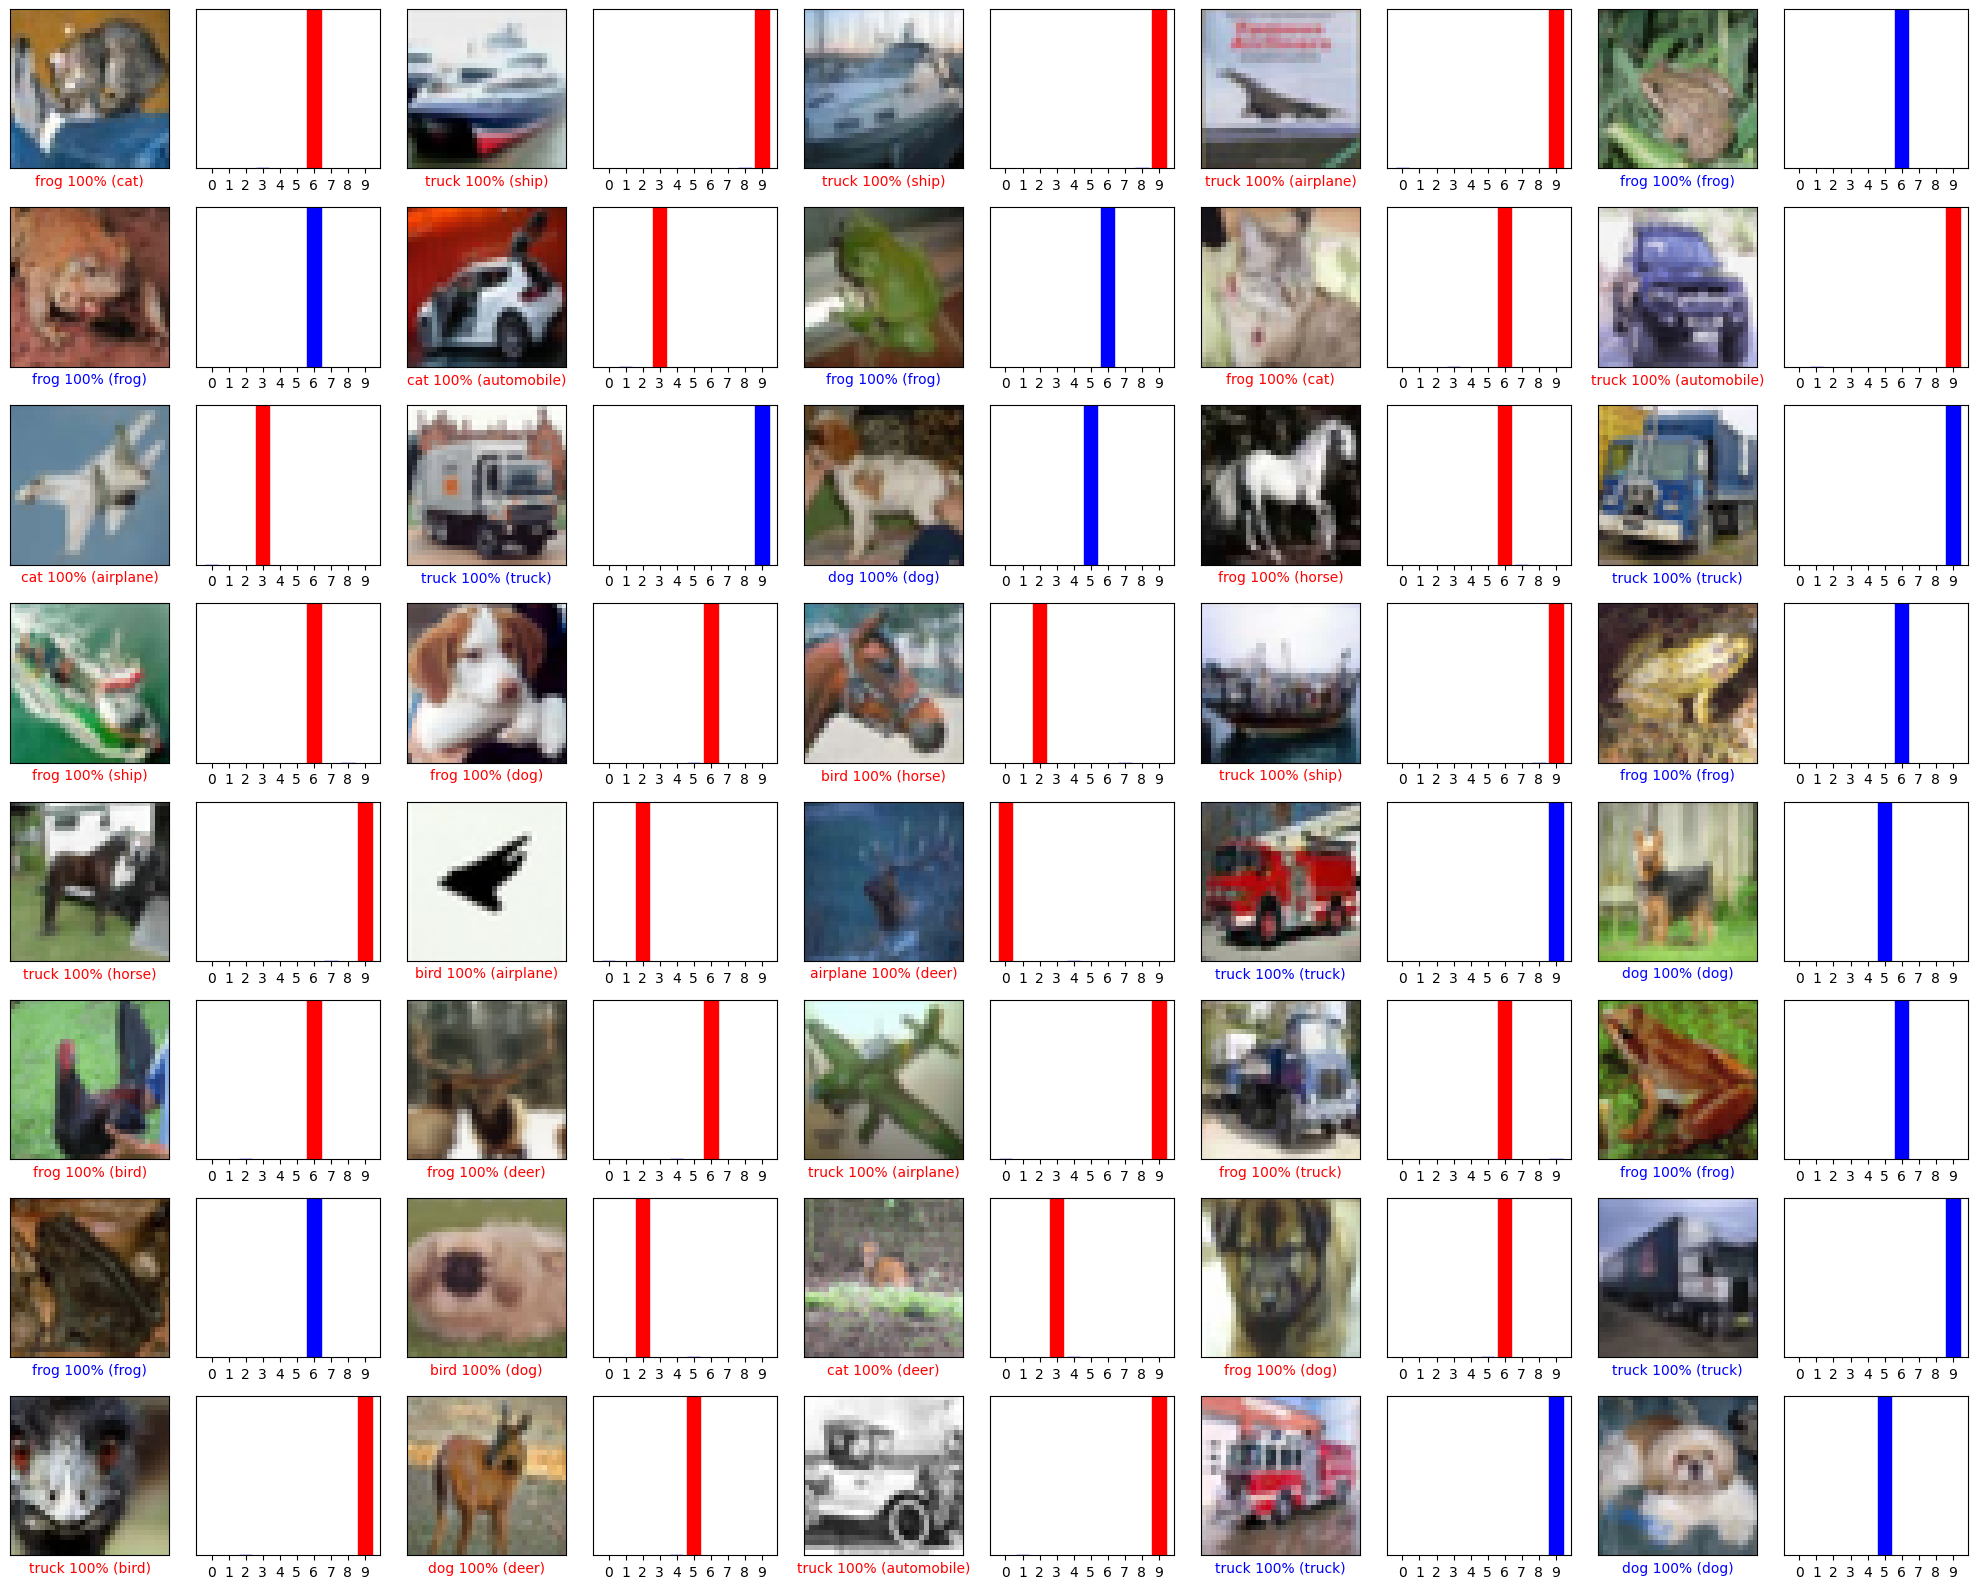

In [78]:
predictions = cnn.predict(X_test)

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

### Algorithm of choice from first six weeks of course
- Random Forest
- SVM

In [79]:
# X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(
#     X_train_flat, y_train, test_size=0.2, random_state=42
# )


# model_rf = classification_model.random_forest(bootstrap=False)

# # Hyperparameter tuning for Random Forest
# rf  = classification_model.tune_model(model = model_rf[0], param_grid=model_rf[1], cv_folds=10, X_train = X_train_flat, y_train = y_train, X_test = X_test_flat, y_test=y_test, use_pca = False)


# print(f"Accuracy: {rf[1]}, Best Parameters: {rf[0]}")
# # --- Train on a subset for speed (optional) ---
# rf.fit(X_train_rf, y_train_rf)

# # --- Predict on validation set ---
# y_pred_val = rf.predict(X_val_rf)  # smaller batch for quick test

# # --- Evaluate accuracy ---
# acc = accuracy_score(y_val_rf, y_pred_val)
# print(f"Validation Accuracy: {acc:.4f}")

### Fully connected neural network

In [80]:
tuner_mlp_no_image = RandomSearch(
    classification_model.tuning_mlp,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='mlp_tuner',
    project_name='cifar10_mlp'
)

tuner_mlp_no_image.search(
    X_small_norm, y_small_cat,
    validation_data=(X_test_small_norm, y_test_small_cat),
    epochs=50,
    batch_size=64
)
mlp_best_model_no_image = tuner_mlp_no_image.get_best_models(num_models=1)[0]
mlp_best_hp_no_image = tuner_mlp_no_image.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", mlp_best_hp_no_image.values)

y_pred = mlp_best_model_no_image.predict(X_test_small_norm)
y_true = y_test_small_cat.argmax(axis=1)
y_pred_classes = y_pred.argmax(axis=1)

acc_mlp_no_image = accuracy_score(y_true, y_pred_classes)
f1_mlp_no_image= f1_score(y_true, y_pred_classes, average='macro')

print(f"Test Accuracy: {acc_mlp_no_image:.4f}, F1-score: {f1_mlp_no_image:.4f}")

Trial 10 Complete [00h 00m 11s]
val_accuracy: 0.3499999940395355

Best val_accuracy So Far: 0.39500001072883606
Total elapsed time: 00h 01m 33s
Best Hyperparameters: {'num_layers': 1, 'units_0': 512, 'dropout_0': 0.1, 'lr': 0.00010991920429240618, 'units_1': 256, 'dropout_1': 0.1, 'units_2': 256, 'dropout_2': 0.1, 'units_3': 128, 'dropout_3': 0.1}
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Test Accuracy: 0.3950, F1-score: 0.3613


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [81]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_gen_mlp = data_generator.flow(X_train_norm, y_train_cat, batch_size)
steps_per_epoch = X_train_norm.shape[0] // batch_size

In [82]:


tuner_mlp_with_image = RandomSearch(
    classification_model.tuning_mlp,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='mlp_tuner_image',
    project_name='cifar10_mlp'
)

tuner_mlp_with_image.search(
    train_gen_mlp,
    validation_data=(X_test_small_norm, y_test_small_cat),
    epochs=50,
    steps_per_epoch=len(X_small_norm)//64,
    verbose=1
)

mlp_best_model_image = tuner_mlp_with_image.get_best_models(num_models=1)[0]
mlp_best_hp_image = tuner_mlp_with_image.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", mlp_best_hp_image.values)

y_pred = mlp_best_model_image.predict(X_test_small_norm)
y_true = y_test_small_cat.argmax(axis=1)
y_pred_classes = y_pred.argmax(axis=1)

acc_mlp_image = accuracy_score(y_true, y_pred_classes)
f1_mlp_image= f1_score(y_true, y_pred_classes, average='macro')

print(f"Test Accuracy: {acc_mlp_image:.4f}, F1-score: {f1_mlp_image:.4f}")

Trial 6 Complete [00h 00m 12s]
val_accuracy: 0.23250000178813934

Best val_accuracy So Far: 0.33500000834465027
Total elapsed time: 00h 01m 08s

Search: Running Trial #7

Value             |Best Value So Far |Hyperparameter
5                 |2                 |num_layers
256               |128               |units_0
0.1               |0.1               |dropout_0
0.0022222         |0.0011692         |lr
128               |128               |units_1
0.1               |0.1               |dropout_1
512               |128               |units_2
0.1               |0.1               |dropout_2
128               |None              |units_3
0.1               |None              |dropout_3
256               |None              |units_4
0.1               |None              |dropout_4

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.1143 - loss: 2.4677 - val_accuracy: 0.1325 - val_loss: 2.2468
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1404 - loss: 2.2497 - va

KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=(12, 16))

# plt.subplot(4, 2, 1)
# plt.plot(r.history['loss'], label='Loss')
# plt.plot(r.history['val_loss'], label='val_Loss')
# plt.title('Loss Function Evolution')
# plt.legend()

# plt.subplot(4, 2, 2)
# plt.plot(r.history['accuracy'], label='accuracy')
# plt.plot(r.history['val_accuracy'], label='val_accuracy')
# plt.title('Accuracy Function Evolution')
# plt.legend()

# plt.subplot(4, 2, 3)
# plt.plot(r.history['precision'], label='precision')
# plt.plot(r.history['val_precision'], label='val_precision')
# plt.title('Precision Function Evolution')
# plt.legend()

# plt.subplot(4, 2, 4)
# plt.plot(r.history['recall'], label='recall')
# plt.plot(r.history['val_recall'], label='val_recall')
# plt.title('Recall Function Evolution')
# plt.legend()

### Convolutional neural network

In [ ]:

tuner_cnn_no_image = RandomSearch(
    classification_model.tuning_cnn,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_tuner',
    project_name='cifar10_cnn'
)

tuner_cnn_no_image.search(
    X_small_norm, y_small_cat,
    validation_data=(X_test_small_norm, y_test_small_cat),
    epochs=50,
    batch_size=64
)

cnn_best_model_no_image = tuner_cnn_no_image.get_best_models(num_models=1)[0]
cnn_best_hp_no_image = tuner_cnn_no_image.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:", cnn_best_hp_no_image.values)

y_pred = cnn_best_model_no_image.predict(X_test_small_norm)
y_true = y_test_small_cat.argmax(axis=1)
y_pred_classes = y_pred.argmax(axis=1)

acc_cnn_no_image = accuracy_score(y_true, y_pred_classes)
f1_cnn_no_image= f1_score(y_true, y_pred_classes, average='macro')

print(f"Test Accuracy: {acc_cnn_no_image:.4f}, F1-score: {f1_cnn_no_image:.4f}")

Trial 10 Complete [00h 02m 20s]
val_accuracy: 0.5099999904632568

Best val_accuracy So Far: 0.5299999713897705
Total elapsed time: 00h 30m 11s


In [ ]:
X_train_norm.shape
y_train_cat.shape

(50000, 10)

In [ ]:
tuner_cnn_with_image = RandomSearch(
    classification_model.tuning_cnn,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_image_tuner',
    project_name='cifar10_cnn'
)

tuner_cnn_with_image.search(
    train_gen_mlp,
    validation_data=(X_test_norm, y_test_cat),
    epochs=50,
    steps_per_epoch=len(X_test_norm)//32,
    verbose=1
)



Trial 2 Complete [00h 45m 49s]
val_accuracy: 0.7901999950408936

Best val_accuracy So Far: 0.796999990940094
Total elapsed time: 01h 08m 33s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
64                |32                |filters1
64                |64                |filters1_2
0.25              |0.3               |dropout1
128               |64                |filters2
64                |64                |filters2_2
0.35              |0.2               |dropout2
256               |128               |filters3
128               |256               |filters3_2
0.2               |0.2               |dropout3
128               |256               |dense_units
0.25              |0.4               |dense_dropout
0.01              |0.001             |learning_rate

Epoch 1/50
254/312 ━━━━━━━━━━━━━━━━━━━━ 18s 324ms/step - accuracy: 0.1401 - loss: 3.7644

KeyboardInterrupt: 

In [ ]:
best_model_cnn_image = tuner_cnn_with_image.get_best_models(num_models=1)[0]
best_hp_cnn_image = tuner_cnn_with_image.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hp_cnn_image.values)

y_pred = best_model_cnn_image.predict(X_test_small_norm)
y_true = y_test_small_cat.argmax(axis=1)
y_pred_classes = y_pred.argmax(axis=1)

acc = accuracy_score(y_true, y_pred_classes)
f1 = f1_score(y_true, y_pred_classes, average='macro')

evaluation = model.evaluate(X_test, y_test_cat)


print(f"Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}")

Best Hyperparameters: {'num_conv_blocks': 1, 'filters_0': 32, 'filters2_0': 32, 'dropout_0': 0.2, 'dense_units': 64, 'dense_dropout': 0.2, 'lr': 0.00025414194281719714, 'filters_1': 128, 'filters2_1': 64, 'dropout_1': 0.2, 'filters_2': 32, 'filters2_2': 64, 'dropout_2': 0.2, 'filters_3': 32, 'filters2_3': 128, 'dropout_3': 0.2, 'filters_4': 128, 'filters2_4': 128, 'dropout_4': 0.2}
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Accuracy: 0.4750, F1-score: 0.4487


/Users/stephensusanto/Library/Python/3.9/lib/python/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Algorithm of choice from first six weeks of course

### Fully connected neural network

### Convolutional neural network